# Project 3: Tennis

---

In this notebook, I am going to implement the tennis agent of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). 

This notebook is successfully solving the project via a two agent DDPG algorithm that share a common replay buffer but sampling individually from it. For more details also have a look at the [Readme](./README.md) of the project.

After training the agent, the neural network models for the actor and critic of each agent (as well as the replay buffer), will be saved to disk. You can use notebook [tennis-play](./tennis-play.ipynb) to load the neural network models and to see the agent in action.

## 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from modules.ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. You can decide between headless and visual option. However, the headless option is a lot faster and at the end, the weights of the neural network will be stored to disk. You can use the trained weights in notebook [tennis-play](./tennis-play.ipynb), there we will just run the agent in a visual environment and you can see your agent in action.

- **Linux** (x86_64): `"./Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86_64, headless): `"./Tennis_Linux_NoVis/Tennis.x86_64"`

In [2]:
env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

For this notebook, we decided to give each agent its own learning capabilites. But they do share the same replay buffer. The agents goal is to control a racket to bounce a ball over a net. At each time step the agents have to choose the correct continuous action that consists of a vector of two entries. They correspond to the movement toward or away from the net, and jumping. Each entry in the vector should be a number between -1 and +1:
- `x1` (-1; +1)
- `x2` (-1; +1)

The state space has `8` dimensions and corresponds to the position and velocity of the ball and racket. A reward of `+0.1` is provided for hitting the ball over the net. A negative reward of `-0.01` is provided if the ball hit the ground or is out of bounds.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

numberOfActions = action_size
numberOfStates = state_size

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Define the main ddpg function and some helper functions

In [5]:
def ddpg(agents, n_episodes, max_t):
    environment_solved = False
    
    all_scores = []                                         # list the max score after each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
        states = env_info.vector_observations               # get the current state (for each agent)
        agent.reset()                                       # reset the agent

        scores = np.zeros(num_agents)                       # initialize the score (for each agent)
        score = 0                                           # initialize the score
        
        #for t in range(max_t):
        while(True):
            actions = agent.act(states)            # select an action (for each agent)
            env_info = env.step(actions)[brain_name]        # send the actions to the environment

            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards = env_info.rewards                      # get reward (for each agent)
            dones = env_info.local_done                     # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)      
            
            states = next_states                            # roll over the state to next time step
            scores += rewards                               # update the score
            if np.any(dones):                               # exit loop if episode finished
                break 

        score = np.max(scores)
        
        scores_window.append(score)       # save most recent score
        all_scores.append(score)              # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) > 0.5 and environment_solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            environment_solved = True
            
        if i_episode % 1000 == 0:
            agent.save("./models/ddpg_")
            
    return all_scores

def printPlot(title, scores, movingAverage=100):
    # plot the scores
    fig = plt.figure(1, figsize=(12, 12))
    
    mvgAvg = []
    scores_window = deque(maxlen=movingAverage)
    for s1 in scores:
        scores_window.append(s1)
        mvgAvg.append(np.mean(scores_window))    
    
    ax1 = fig.add_subplot(1,1,1)
    plt.plot(np.arange(len(scores)), scores, np.arange(len(scores)), mvgAvg)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    
    plt.show()    
    
def writeScoreToFile(filename, scores):
    file = open("./models/" + filename, "w") 
 
    for score in scores:
        file.write(str(score) + "\n")
        
    file.close()

## 4. Run the DDGP algorithm

In [6]:
LR_ACTOR = 1e-5
LR_CRITIC = 1e-4
WEIGHT_DECAY_CRITIC = 0.0
REPLAY_BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
UPDATE_EVERY = 3
GAMMA = 0.99
TAU = 0.001
SEED = 0
MY_DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_episodes = 5000    # n_episodes (int): maximum number of training episodes
max_t = 1000

In [7]:
agent = Agent.for_training(
            number_of_agents=num_agents,
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            lr_actor=LR_ACTOR,
            lr_critic=LR_CRITIC,
            weight_decay_critic=WEIGHT_DECAY_CRITIC,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=MY_DEVICE)

scores_ddpg = ddpg(agent, n_episodes, max_t)
agent.save("./models/ddpg_")

cuda:0
Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.03
Episode 1200	Average Score: 0.04
Episode 1300	Average Score: 0.03
Episode 1400	Average Score: 0.04
Episode 1500	Average Score: 0.02
Episode 1600	Average Score: 0.03
Episode 1700	Average Score: 0.05
Episode 1800	Average Score: 0.02
Episode 1900	Average Score: 0.06
Episode 2000	Average Score: 0.06
Episode 2100	Average Score: 0.04
Episode 2200	Average Score: 0.03
Episode 2300	Average Score: 0.04
Episode 2400	Average Score: 0.02
Episode 2500	Average Score: 0.04
Episode 2600	Average Score: 0.05
Episode 2700	Average Score: 0.02
Episode 2800	Average Score: 0.03
Episode 2900	Average Score: 0.03
Episode 3000	Average Score: 0.07
Episode 3100

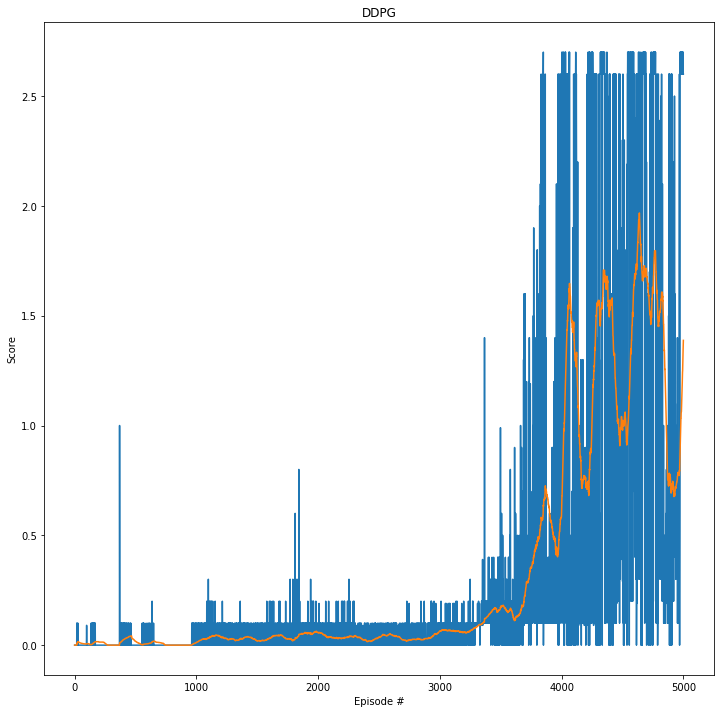

In [8]:
# plot the scores
printPlot("DDPG", scores_ddpg, 100)
writeScoreToFile("ddpg_scores.txt", scores_ddpg)

In [9]:
env.close()